In [16]:
# I run this in my misdeed environment

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from misdeed.OmicsGenerator import OmicsGenerator
from src.phylogenetic_signal import PagelsLambda
import ete3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
gen = OmicsGenerator(
    node_sizes = [100],
    init_full=True,
    time_points=30,
)

z, x, y = gen.generate_multiple(10)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:100    0:100
Added x0 vector to node n0
Added growth rates to node n0
Initialized


100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


In [49]:
gen._interactions[0].matrix

array([[-5.24264069,  0.        ,  0.62824492, ...,  0.4472813 ,
        -1.43912982, -0.78319303],
       [ 0.        , -5.24264069, -0.        , ..., -0.        ,
        -0.98570978, -0.94487728],
       [ 0.62147094,  0.        , -5.24264069, ..., -0.        ,
         0.27529716,  0.        ],
       ...,
       [ 1.09540128,  0.        ,  0.        , ..., -5.24264069,
        -0.        ,  1.67215713],
       [ 0.15975146,  0.68969218, -1.60499327, ...,  0.        ,
        -5.24264069, -0.        ],
       [ 1.0098821 ,  1.0723629 , -0.        , ..., -1.3685275 ,
         0.        , -5.24264069]])

  0%|          | 0/10 [00:00<?, ?it/s]/home/phil/miniconda3/envs/misdeed/lib/python3.6/site-packages/misdeed/OmicsGenerator.py:876: RuntimeWarning: invalid value encountered in true_divide
  x = np.apply_along_axis(lambda a: a/sum(a), 1, x)
  0%|          | 0/10 [00:00<?, ?it/s]/home/phil/miniconda3/envs/misdeed/lib/python3.6/site-packages/misdeed/OmicsGenerator.py:802: RuntimeWarning: overflow encountered in multiply
  return xt * (growth_rates + interaction_coef + intervention_coef)
/home/phil/miniconda3/envs/misdeed/lib/python3.6/site-packages/scipy/integrate/_ivp/common.py:110: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/home/phil/miniconda3/envs/misdeed/lib/python3.6/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in subtract
  d2 = norm((f1 - f0) / scale) / h0
 20%|██        | 2/10 [00:00<00:01,  5.11it/s]/home/phil/miniconda3/envs/misdeed/lib/python3.6/site-packages/scipy/integrate/_ivp/common

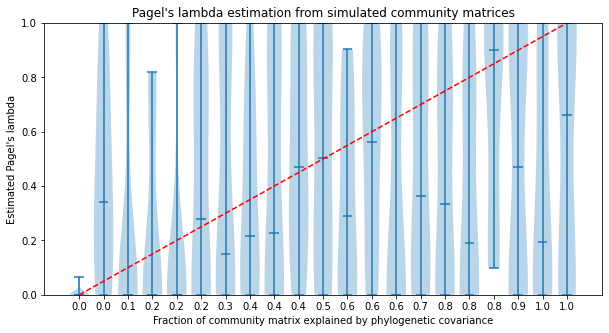

In [74]:
pl = PagelsLambda("results/ibd_tree_top100.nwk", format=1)
C = pl.C / np.max(pl.C)

all_est_lambdas = []
true_lambdas = np.linspace(0, 1, 21)
for lam in true_lambdas:
    # Initialize generator and generate data
    gen = OmicsGenerator(
        node_sizes=[100], init_full=True, time_points=30, C=1, silent=True
    )

    # Set lambda in matrix (imitate Allesina normal form)
    original_diag = gen._interactions[0].matrix.diagonal()
    gen._interactions[0].matrix = (
        lam * C + (1 - lam) * gen._interactions[0].matrix
    )
    gen._interactions[0].matrix[
        np.diag_indices_from(gen._interactions[0].matrix)
    ] = original_diag

    z, x, y = gen.generate_multiple(10)

    # Estimate lambda
    est_lambdas = []
    for patient in y:
        try:
            # Compute matrix of log-differences:
            log_abundances = np.log(patient["n0"] + 1e-10)
            diffs = np.diff(log_abundances, axis=0)

            # Pull out a random time point
            n_timepoints, n_otus = diffs.shape
            random_idx = np.random.randint(0, n_timepoints)
            sample = diffs[random_idx, :]
            pl.fit(sample)
            est_lambdas.append(pl.lam)
        except:
            est_lambdas.append(np.nan)
    all_est_lambdas.append(est_lambdas)

fig = plt.figure(figsize=(10, 5))
plt.violinplot(
    dataset=all_est_lambdas,
    positions=true_lambdas,
    widths=[0.04] * len(true_lambdas),
    showmedians=True,
)
plt.plot(true_lambdas, true_lambdas, color="red", linestyle="--")
plt.xticks(true_lambdas, np.round(true_lambdas, 1))
plt.ylim(0, 1)
plt.xlabel("Fraction of community matrix explained by phylogenetic covariance")
plt.ylabel("Estimated Pagel's lambda")
plt.title("Pagel's lambda estimation from simulated community matrices")
plt.show()


In [65]:
gen._interactions[0].matrix

array([[-5.24264069,  0.10084   ,  0.09358   , ...,  0.0212    ,
         0.        ,  0.        ],
       [ 0.10084   , -5.24264069,  0.09358   , ...,  0.0212    ,
         0.        ,  0.        ],
       [ 0.09358   ,  0.09358   , -5.24264069, ...,  0.0212    ,
         0.        ,  0.        ],
       ...,
       [ 0.0212    ,  0.0212    ,  0.0212    , ..., -5.24264069,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -5.24264069,  0.01833   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01833   , -5.24264069]])

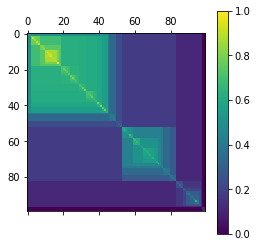

In [71]:
plt.matshow(pl.C / pl.C.max(axis=(0,1)))
plt.colorbar(